In [314]:
import pandas
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from importlib import reload
import glob 
from sklearn.preprocessing import Imputer
from importlib import reload

import specplotlib
import dataprocess
import alphabeta

# Import Data

In [208]:
kpr_df = pandas.read_csv('/Users/natalie/git/SNIa/df_kpr/kpra_union_df.csv')
sn_names = numpy.load('/Users/natalie/git/SNIa/df_kpr/kpra_sn_names.npy')
W_kpr = numpy.load('/Users/natalie/git/SNIa/df_kpr/W_db.npy')
W_kpr = W_kpr[0] # since it is the same grid
F_kpr = numpy.load('/Users/natalie/git/SNIa/df_kpr/F_db.npy')

# Choose the Bin


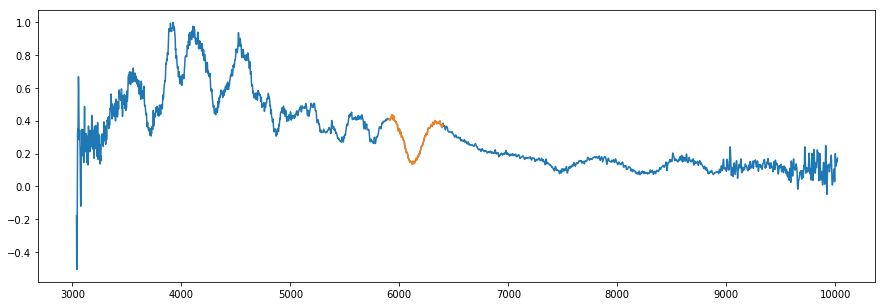

In [204]:
min_wl = 5900 # real wl
max_wl = 6400
idx_min, val_min = dataprocess.find_nearest(W_kpr,min_wl)
idx_max, val_max = dataprocess.find_nearest(W_kpr,max_wl)
gap = 0.5

# plot 2 spectra to see the difference
fig, ax = plt.subplots(1,1, figsize=(15,5))

ax.plot(W_kpr, F_kpr[55])
ax.plot(W_kpr[idx_min:idx_max], F_kpr[55,idx_min:idx_max])

plt.show()

# Processing

In [226]:
reload(kpra_funcs)

# find the idx_kpr (also the idx of F_kpr) that match the tol critiria - ordered according to sn_names order
idx = dataprocess.select_spec_from_peak_by_bin(kpr_df, F_kpr, W_kpr, 0.80, sn_names, min_wl, max_wl)

# create a matrix with spectra for good sne according to returned idx and nans for not
F_si6130, use_inds = dataprocess.create_umap_flux_mat(F_kpr, sn_names, idx, idx_min, idx_max)
# now F_si6130 has nans where the sne fails the cut and the spectra where it is good and use_inds is where the spectra and real and not nans

# the impute will make the sne with nans have the median spectra of all batch, since we can't run umap with nans
F_si6130[use_inds], W_si6130 = dataprocess.impute_spec(F_si6130[use_inds], W_kpr[idx_min:idx_max]) 

# normalize the spectra again according to the median of the choosen bin
F_si6130[use_inds] = dataprocess.norm_by_bin(F_si6130[use_inds])


# Umap

/Users/natalie/anaconda2/envs/fun/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


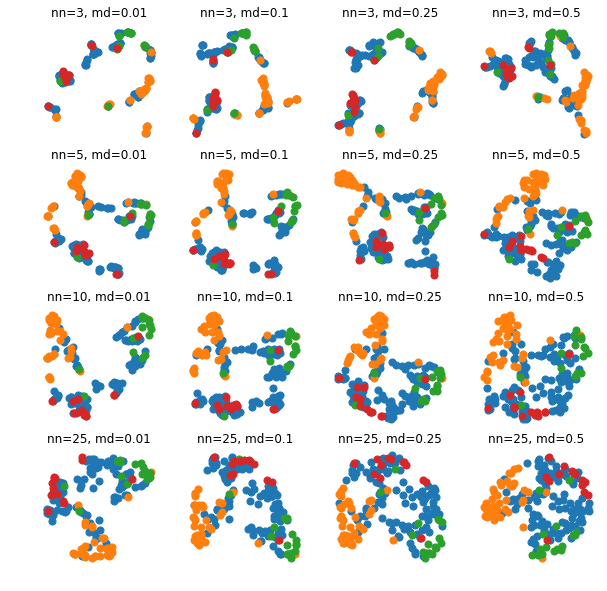

In [231]:
# checka a few u-maps
# fit with umap distance calculation using default matrix (uclidiean) - with only sne with good spectra (not median), color by groups
c = numpy.load('/Users/natalie/git/SNIa/colors_kpr/WClass.npy')
specplotlib.umap_param_scan(F_si6130[use_inds], save=False, c=c[use_inds])

In [234]:
# create the chosen u-map
t_umap = umap.UMAP(n_neighbors=10,min_dist=0.01).fit_transform(F_si6130[use_inds])
all_umap = numpy.ones([F_si6130.shape[0],2])
all_umap[use_inds] = t_umap

/Users/natalie/anaconda2/envs/fun/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


# Groups Coloring

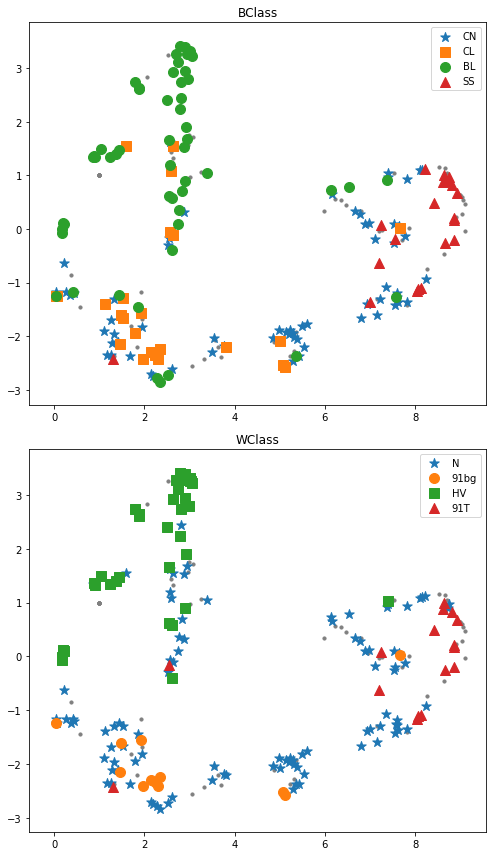

In [237]:
reload(specplotlib)

Bclass = numpy.load('/Users/natalie/git/SNIa/colors_kpr/BClass_nat.npy')
Wclass = numpy.load('/Users/natalie/git/SNIa/colors_kpr/WClass_nat.npy')

specplotlib.kpr_color_by_groups(all_umap, Bclass, Wclass)

# Spectra Coloring

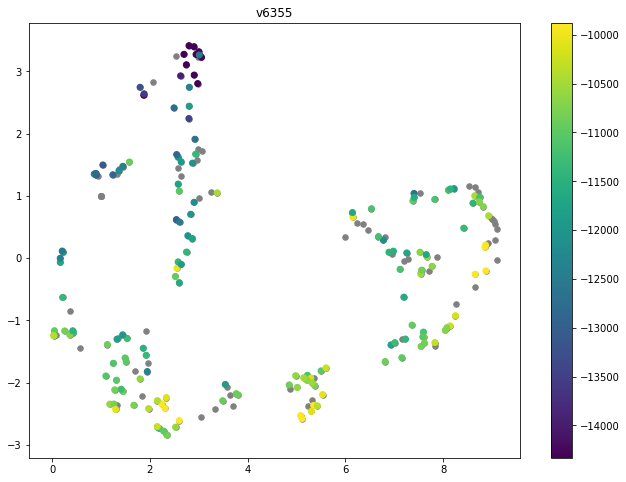

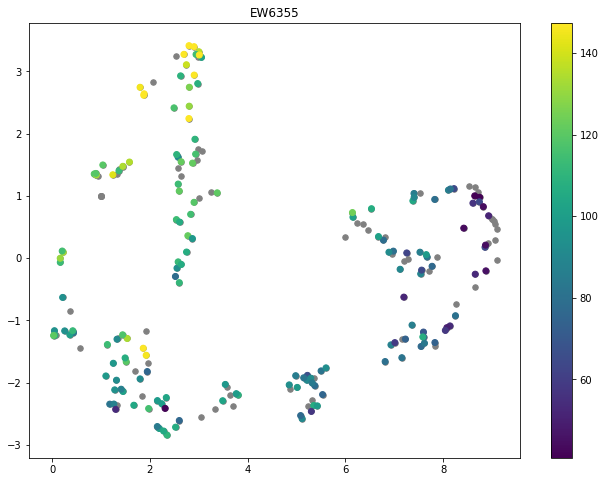

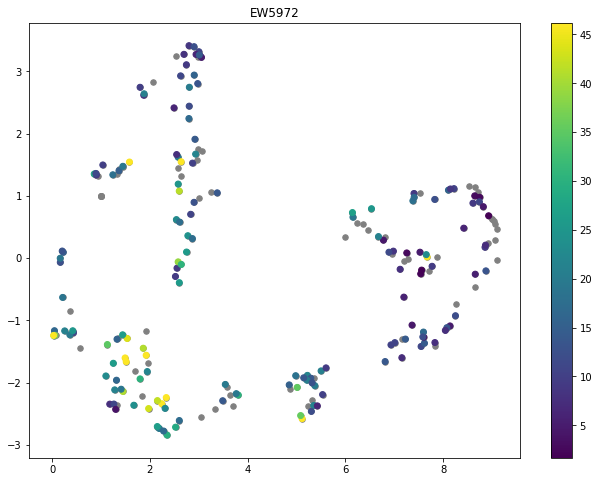

In [238]:
reload(specplotlib)

v6 = numpy.load('/Users/natalie/git/SNIa/colors_kpr/v6355_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, 'v6355', v6, low_prec=5, high_prec=95)

ew6 = numpy.load('/Users/natalie/git/SNIa/colors_kpr/EW6355_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, 'EW6355', ew6, low_prec=1, high_prec=95)

ew5 = numpy.load('/Users/natalie/git/SNIa/colors_kpr/EW5972_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, 'EW5972', ew5, low_prec=1, high_prec=95)

# LC Coloring

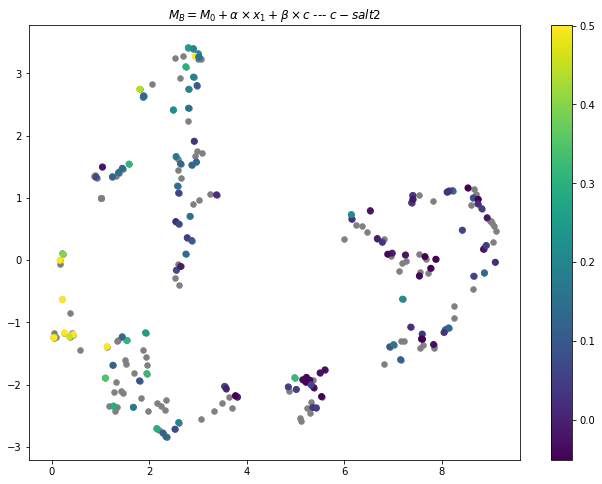

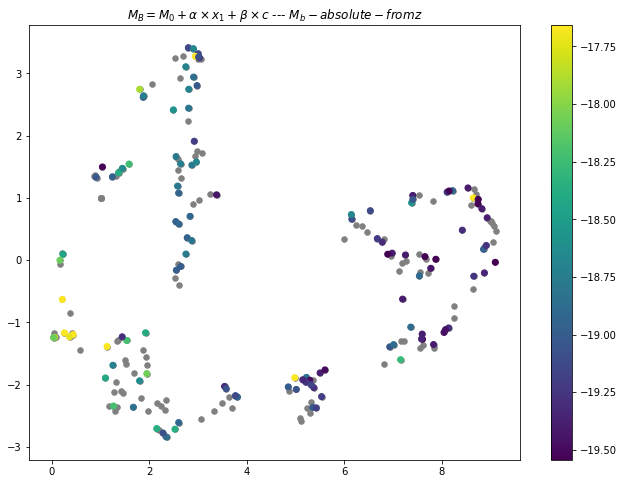

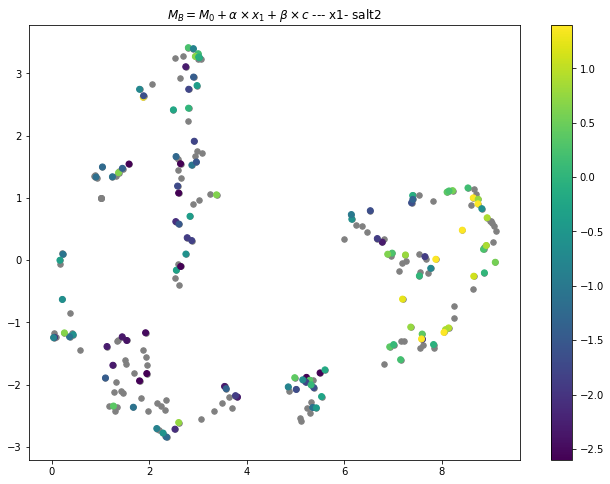

In [243]:
reload(specplotlib)

c_param = numpy.load('/Users/natalie/git/SNIa/colors_kpr/c_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, r'$M_{B} = M_{0} + \alpha \times x_1 + \beta \times c$ --- $c-salt2$', c_param, low_prec=5, high_prec=95)

Mb = numpy.load('/Users/natalie/git/SNIa/colors_kpr/Mb_abs_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, r'$M_{B} = M_{0} + \alpha \times x_1 + \beta \times c$ --- $M_b-absolute - from z$', Mb, low_prec=5, high_prec=95)

x1 = numpy.load('/Users/natalie/git/SNIa/colors_kpr/x1_nat.npy')
specplotlib.kpr_color_by_c_param(all_umap, r'$M_{B} = M_{0} + \alpha \times x_1 + \beta \times c$ --- x1- salt2', x1, low_prec=5, high_prec=95)

### **the Mb presented is not the observed magnitude but the absolute calculated by calculating mu from z (cosmo) and then distance modulus, as detailed in kpr_umap_checks
    

# Phase Coloring

### Since these are different spectra choosen each time, phase list has to be re-built for each map

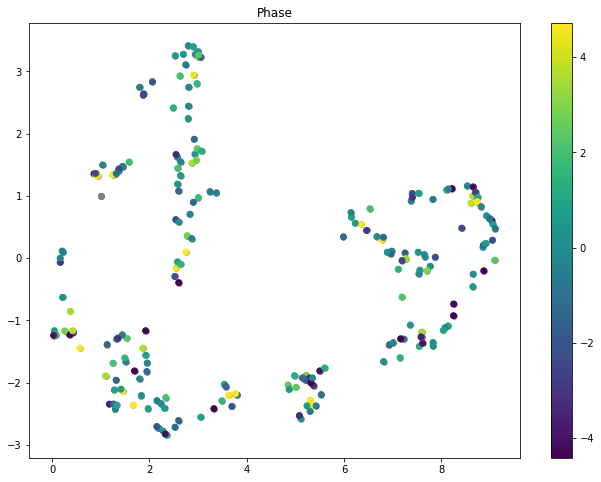

In [240]:
# Phase
idx = numpy.array(idx)
phase = numpy.zeros([len(sn_names)])
for i, i_all in enumerate(idx):
    if numpy.isfinite(i_all):
        i_all = int(i_all)
        phase[i] = kpr_df['phase_kpr'].iloc[i_all]
    else:
        phase[i] = numpy.nan    

specplotlib.kpr_color_by_c_param(all_umap, 'Phase', phase, low_prec=5, high_prec=95)

# SNR Coloring

### Since these are different spectra choosen each time, snr list has to be re-built for each map


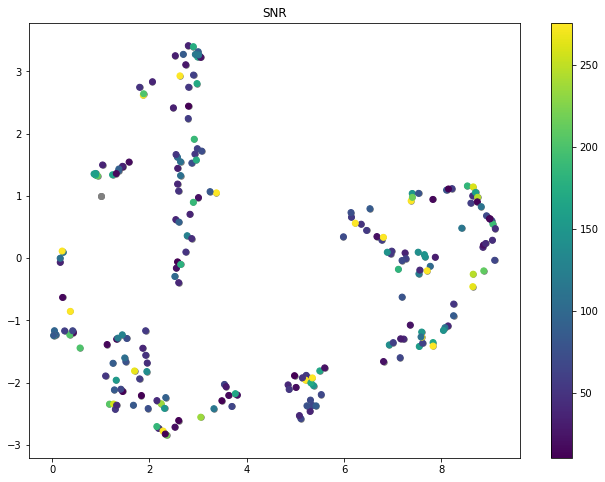

In [241]:
# SNR
idx = numpy.array(idx)
snr = numpy.zeros([len(sn_names)])
for i, i_all in enumerate(idx):
    if numpy.isfinite(i_all):
        i_all = int(i_all)
        snr[i] = kpr_df['snr_kpr'].iloc[i_all]
    else:
        snr[i] = numpy.nan    

specplotlib.kpr_color_by_c_param(all_umap, 'SNR', snr, low_prec=5, high_prec=95)

# Alpha and Betha

In [305]:
# load all colors
z_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/z_nat.npy')
mb_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/mb_nat.npy')
x1_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/x1_nat.npy')
c_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/c_nat.npy')
mb_err_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/mb_err_nat.npy')
x1_err_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/x1_err_nat.npy')
c_err_n = numpy.load('/Users/natalie/git/SNIa/colors_kpr/c_err_nat.npy')

In [486]:
# calculate alpha and beta
reload(alphabeta)
reload(pfit)
M0, alpha, beta, X, dX, Y, dY, has_fitter = alphabeta.fit_nn_salt2(z_n, mb_n, x1_n, c_n, mb_err_n, x1_err_n, c_err_n, 15, all_umap)


In [336]:
# save all sizes
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/all_umap', all_umap)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/beta', beta)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/alpha', alpha)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/M0', M0)

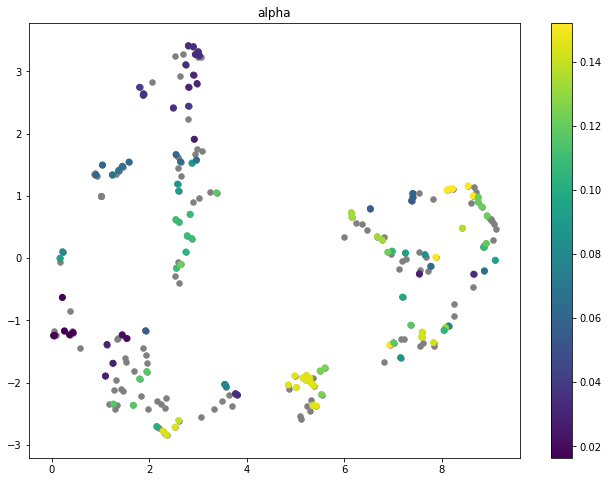

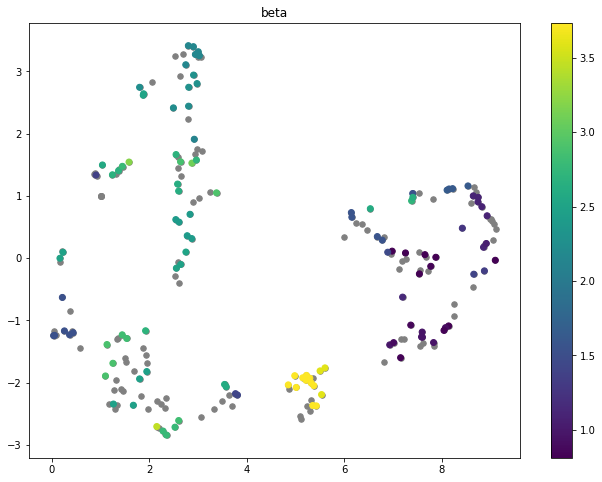

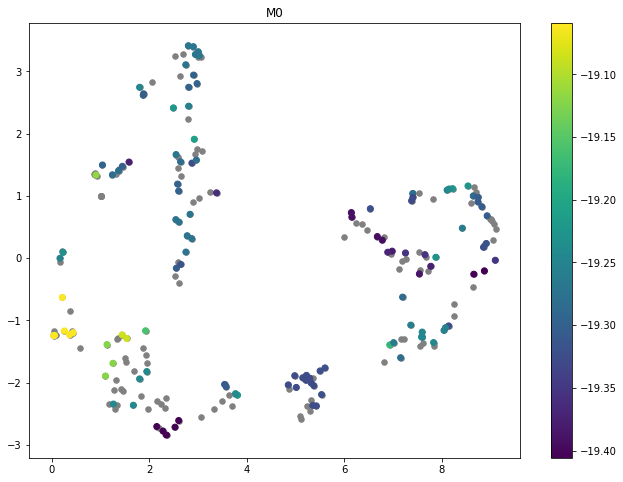

In [467]:
specplotlib.kpr_color_by_c_param(all_umap, 'alpha', alpha, low_prec=5, high_prec=95)
specplotlib.kpr_color_by_c_param(all_umap, 'beta', beta, low_prec=5, high_prec=95)
specplotlib.kpr_color_by_c_param(all_umap, 'M0', M0, low_prec=5, high_prec=95)

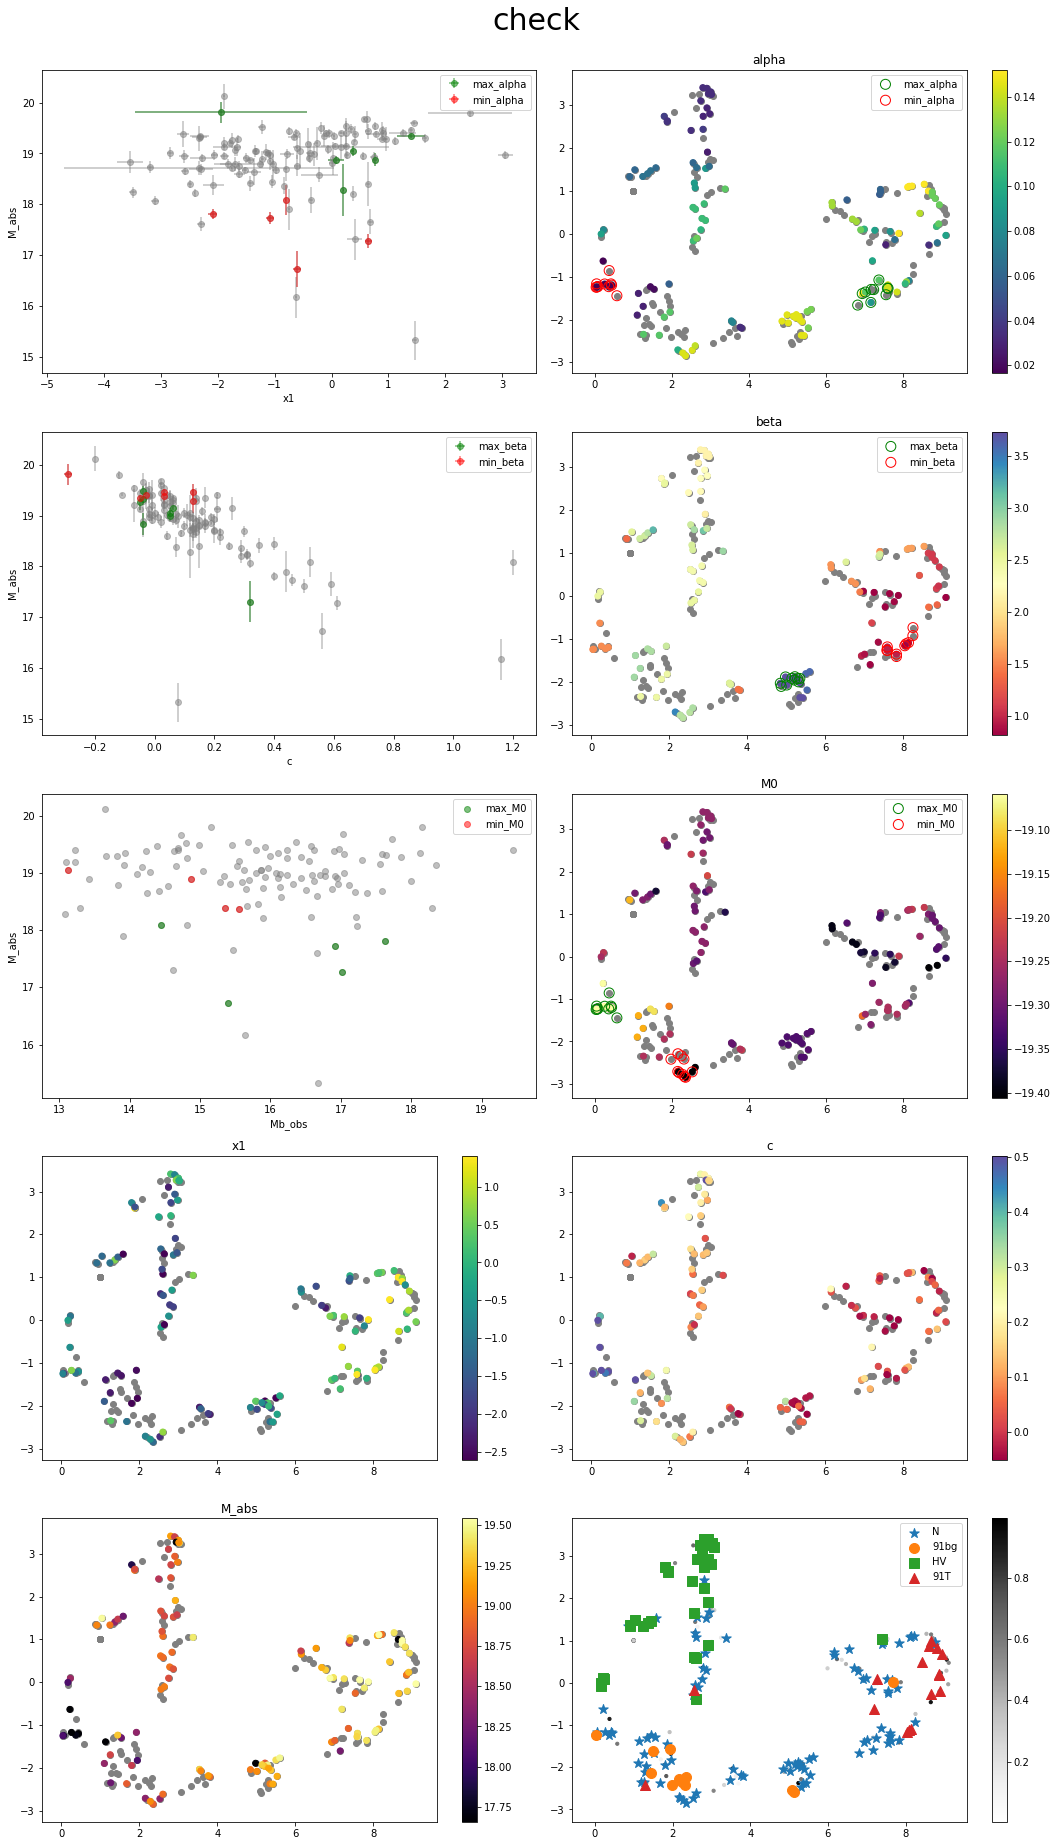

In [602]:
name = 'check'
reload(alphabeta)
reload(pfit)
alphabeta.fit_plot(X, dX, Y, dY, mb_n, M0, alpha, beta, Wclass, all_umap, name, low_prec=5, high_prec=95)

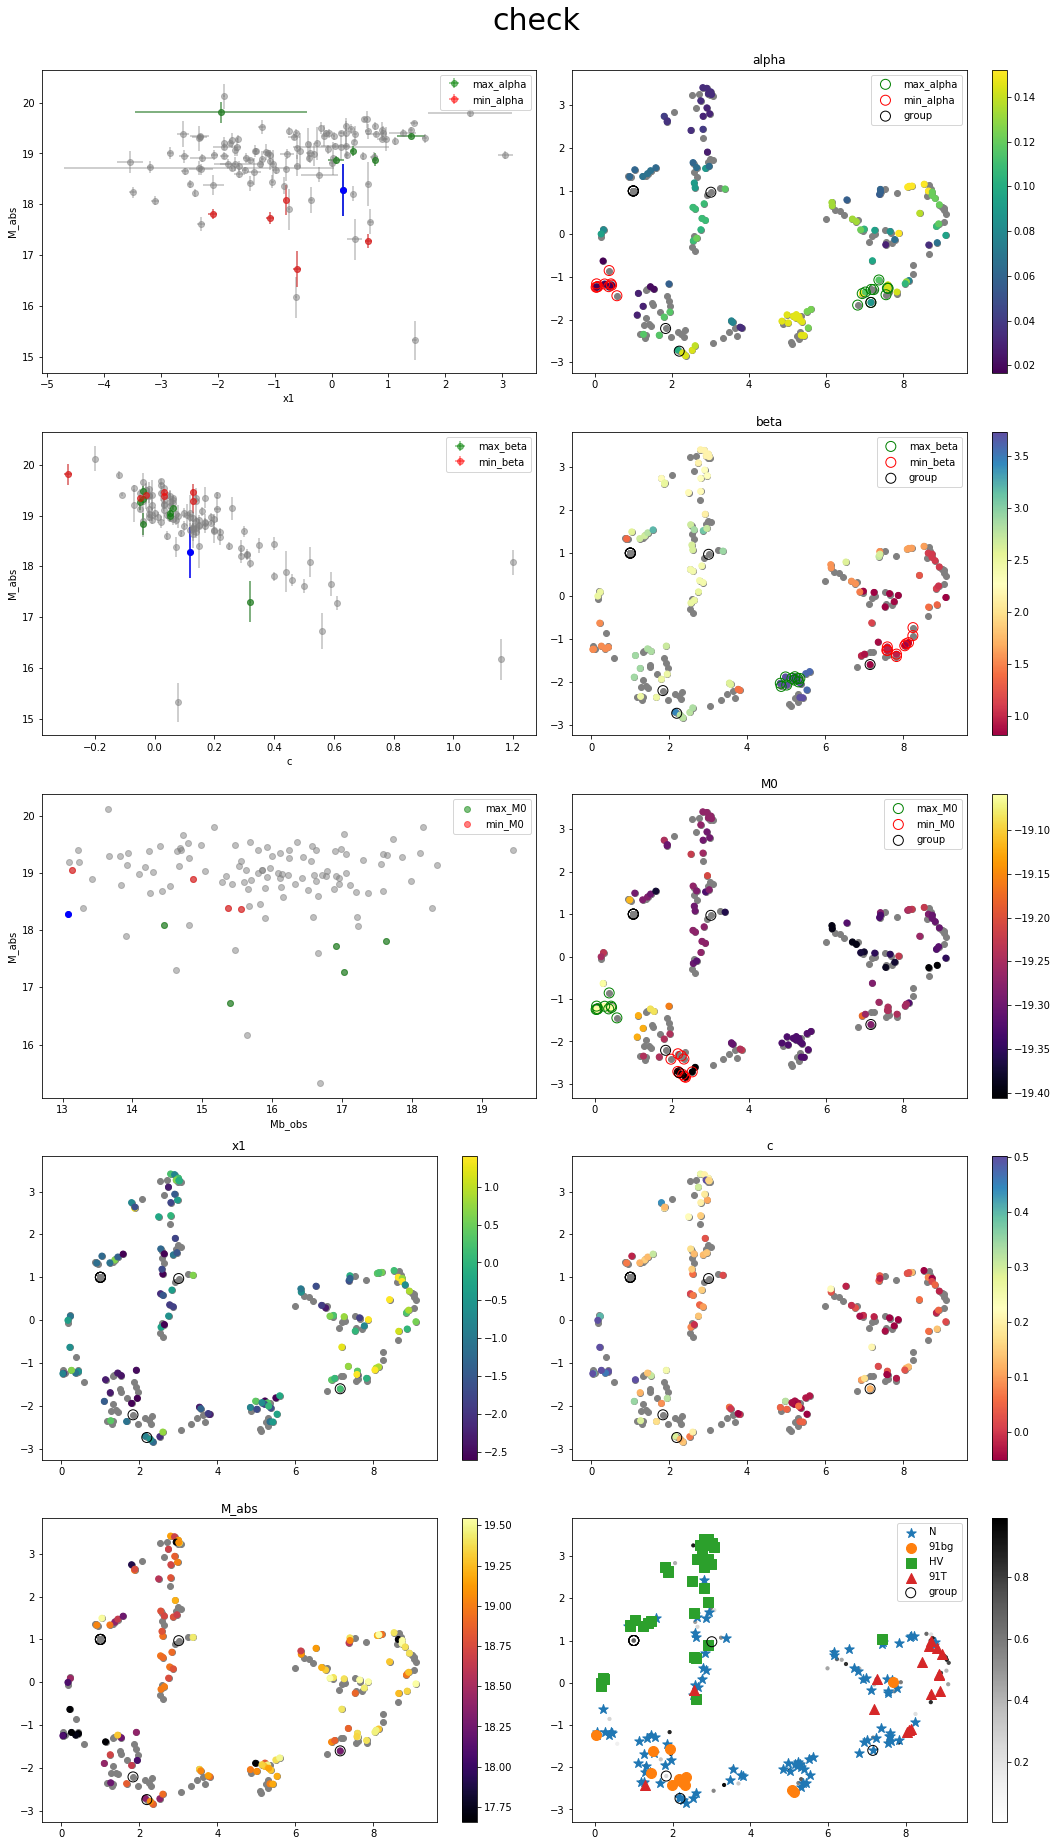

In [604]:
reload(alphabeta)
reload(pfit)
alphabeta.fit_plot(X, dX, Y, dY, mb_n, M0, alpha, beta, Wclass, all_umap, name, g = group, low_prec=5, high_prec=95)

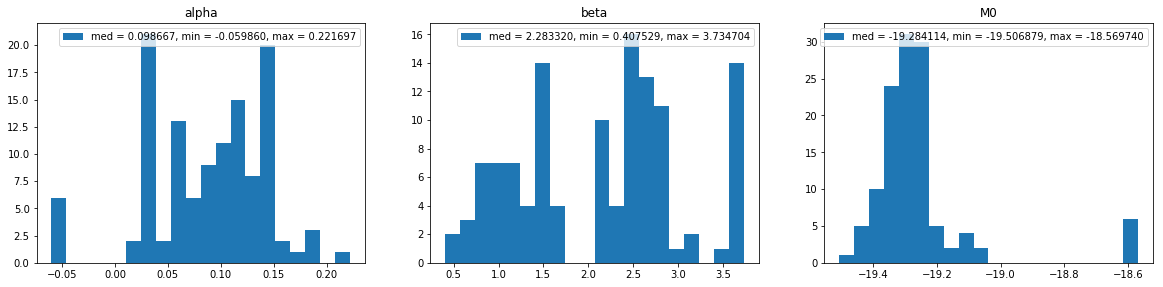

In [473]:
# see all spectra of 5 nn for this sn, one over the other to see if the spectra are similar:
fig = plt.figure(figsize=(20,15))

plt.subplot(331)
plt.hist(alpha[has_fitter], bins=20, label=('med = %f, min = %f, max = %f' %(numpy.median(alpha[has_fitter]), numpy.min(alpha[has_fitter]), numpy.max(alpha[has_fitter]))))
plt.legend()
plt.title('alpha')

plt.subplot(332)
plt.hist(beta[has_fitter], bins=20, label=('med = %f, min = %f, max = %f' %(numpy.median(beta[has_fitter]), numpy.min(beta[has_fitter]), numpy.max(beta[has_fitter]))))
plt.legend()
plt.title('beta')

plt.subplot(333)
plt.hist(M0[has_fitter], bins=20, label=('med = %f, min = %f, max = %f' %(numpy.median(M0[has_fitter]), numpy.min(M0[has_fitter]), numpy.max(M0[has_fitter]))))
plt.legend()
plt.title('M0')

plt.show()


# Hubble diagram and residuals

# Saves and Loads

In [ ]:
"""
SAVES:
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/si6355_umap_080_checks', t_umap)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/W_si6130_080', W_si6130)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/F_si6130_080', F_si6130)
numpy.save('/Users/natalie/git/SNIa/umaps_kpr/use_inds_si6130_080', use_inds)

LOADS:
t_umap = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355/si6355_umap_085.npy')
W_si6130 = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/W_si6130_080')
F_si6130 = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/F_si6130_080')
use_inds = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/use_inds_si6130_080')
"""

# Choosing groups 
### choosing the groups - in choosing_groups notebook - loading here and coloring by it

In [21]:
# load coloring groups
c_salt_1 = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/all_closest_to_peak_0.80/si6355_c_salt_1.npy')
c_salt_2 = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/all_closest_to_peak_0.80/si6355_c_salt_2.npy')

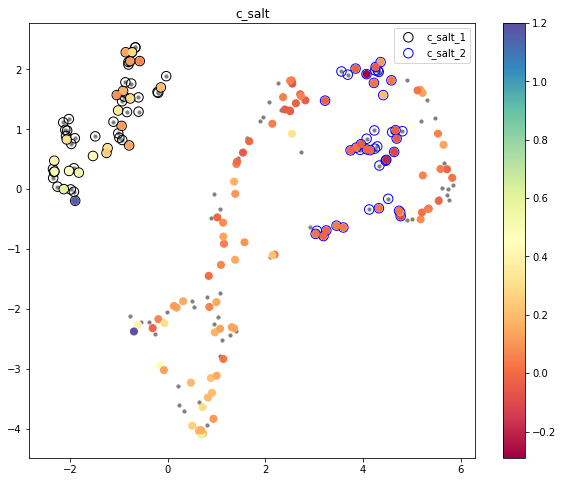

In [813]:
#plt the map in result with groups

%matplotlib inline
plt.figure(figsize=(10,8))

umapmap = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/si6355_umap_080_checks.npy')
x = umapmap[:, 0]
y = umapmap[:, 1]
click_map = umapmap.copy()
use_inds = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/use_inds_si6130_080.npy')
c_param = numpy.load('supernova_toast/kpra/colors/c_nat.npy')
c_param = c_param[use_inds]

plt.title('c_salt')
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[c_salt_1], y[c_salt_1], s=90, facecolors='none', edgecolors='black', label='c_salt_1')
plt.scatter(x[c_salt_2], y[c_salt_2], s=90, facecolors='none', edgecolors='blue', label='c_salt_2')
plt.scatter(x, y, c = c_param, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()

plt.legend()
plt.show()

complete batch:
highest c =  1.2
lowest c =  -0.29
median c =  0.08
avarage c =  0.12875
 
c_salt_1
highest c_1 =  1.16
lowest c_1 =  0.07
median c_1 =  0.29
avarage c_1 =  0.33666666666666667
 
c_salt_2
highest c_2 =  0.21
lowest c_2 =  -0.29
median c_2 =  -0.015
avarage c_2 =  -0.01269230769230769


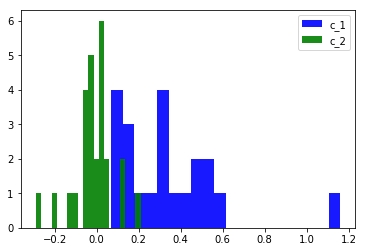

In [839]:
# getting avarage sizes for the choosen groups and coloring parameter

print ("complete batch:")
print ("highest c = ", numpy.nanmax(c_param))
print ("lowest c = ", numpy.nanmin(c_param))
print ("median c = ", numpy.nanmedian(c_param))
print ("avarage c = ", numpy.nanmean(c_param))
print (" ")
print ("c_salt_1")
print ("highest c_1 = ", numpy.nanmax(c_param[c_salt_1]))
print ("lowest c_1 = ", numpy.nanmin(c_param[c_salt_1]))
print ("median c_1 = ", numpy.nanmedian(c_param[c_salt_1]))
print ("avarage c_1 = ", numpy.nanmean(c_param[c_salt_1]))
print (" ")
print ("c_salt_2")
print ("highest c_2 = ", numpy.nanmax(c_param[c_salt_2]))
print ("lowest c_2 = ", numpy.nanmin(c_param[c_salt_2]))
print ("median c_2 = ", numpy.nanmedian(c_param[c_salt_2]))
print ("avarage c_2 = ", numpy.nanmean(c_param[c_salt_2]))

fig, ax = plt.subplots()
c_hist_1 = c_param[c_salt_1]
c_hist_1 = c_hist_1[numpy.isfinite(c_hist_1)]
c_hist_2 = c_param[c_salt_2]
c_hist_2 = c_hist_2[numpy.isfinite(c_hist_2)]
ax.hist(c_hist_1, alpha=0.9, color='blue', bins=20, label='c_1')
ax.hist(c_hist_2, alpha=0.9, color='green', bins=20, label='c_2')
plt.legend()
plt.show()

# Choosing 1 SN

In [864]:
# choose the SNe
sn_ids = numpy.where(sn_names == '1998de')[0]
print(sn_ids)
print(sn_names[sn_ids])
use_sn_ids = numpy.where(use_inds == sn_ids)[0]
print(use_sn_ids)

[36]
['1998de']
[30]


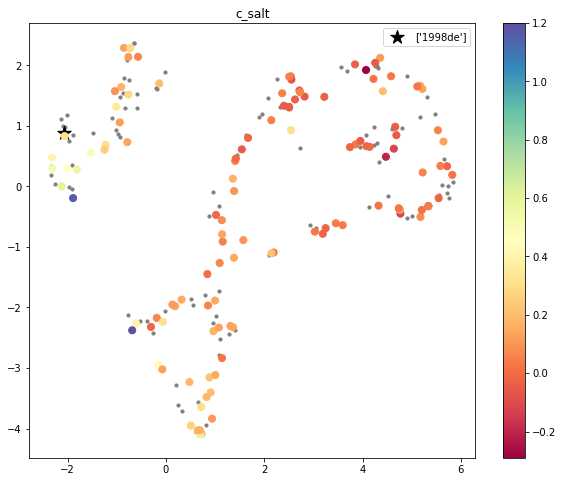

In [867]:
#plt the map with mark on choosen SN

%matplotlib inline
plt.figure(figsize=(10,8))

umapmap = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/si6355_umap_080_checks.npy')
x = umapmap[:, 0] #this is already after [use_inds] because this is what we have sent to the umap
y = umapmap[:, 1]
click_map = umapmap.copy()
use_inds = numpy.load('/Users/natalie/git/SNIa/umaps_kpr/si6355_checks/use_inds_si6130_080.npy')
c_param = numpy.load('supernova_toast/kpra/colors/c_nat.npy')
c_param = c_param[use_inds]

plt.title('c_salt')
plt.scatter(x, y, color = 'gray', s = 10)
plt.scatter(x[use_sn_ids], y[use_sn_ids], s=200, marker='*', facecolors='black', edgecolors='black', label=sn_names[sn_ids])
plt.scatter(x, y, c = c_param, s = 50, cmap="Spectral")
plt.colorbar()
plt.legend()

plt.legend()
plt.show()